# Multi-class Classification (Word2Vec)

In this notebook I am apply different machine learning models to predict the skills that I need from the job descriptions.

## Table of contents

1. [Environment Preparation](#Environment-Preparation)
   1. [Dataset Loading](#Dataset-Loading)
   2. [Noun Chunk Extraction](#Noun-Chunk-Extraction)
   3. [Tensorflow Datasets](#Tensorflow-Datasets)
   4. [Text preprocessing](#Text-Preprocessing)
2. [Word2vec](#Word2vec)
   1. [Model Configuration](#Model-Configuration)
   2. [Performance Configuration](#Performance-Configuration)
   3. [Callbacks](#Callbacks)
   4. [Training](#Training)
   5. [Results and Visualizations](#Results-and-Visualizations)
3. [Export the Model](#Export-the-Model)

## Environment Preparation

### Dataset Loading

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import io
import random
import numpy as np
import pandas as pd                # Data processing
import tqdm                        # Easy loading bar

# Visualization imports
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
sns.set_theme()                    # Seaborn will handle plotting theme
%matplotlib inline

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

In [3]:
from modeling.database import MongoDB

db = MongoDB()
df = pd.DataFrame(list(db.get_all_documents()))

### Noun Chunk Extraction

In [4]:
import spacy

nlp = spacy.load("en_core_web_sm")

noun_phrases = []
for doc in nlp.pipe(df['description'].astype('unicode').values, batch_size=50, n_process=6):
    assert doc.has_annotation("DEP")
    for chunk in doc.noun_chunks:
        noun_phrases.append(chunk.text)

# Swap the following so that the set does not include duplicate phrases
#nouns_phrases_set = list(set(noun_phrases))
nouns_phrases_set = list(noun_phrases)

df = pd.DataFrame(nouns_phrases_set, columns=["chunks"])
len(df)

37201

### Tensorflow Datasets

In [5]:
text_ds = tf.data.Dataset.from_tensor_slices(df)

In [6]:
next(text_ds.batch(5_000).as_numpy_iterator())[:10]

array([[b'The Tech Team\n\nTechnology'],
       [b'everything'],
       [b'we'],
       [b'Dialectica'],
       [b'clients'],
       [b'the most relevant expert profiles'],
       [b'just a few minutes'],
       [b'indexing'],
       [b'thousands'],
       [b'pieces']], dtype=object)

### Text Preprocessing

In [7]:
# Custom standardization function to strip remove uneccessary text and symbols.
def custom_standardization(input_data):
    input_df = tf.strings.lower(input_data)
    input_df = tf.strings.regex_replace(input_df, '(e\.g\.?)|(i\.e\.?).', '')
    input_df = tf.strings.regex_replace(input_df, '[^\u0020-\u007E]', ' ')
    input_df = tf.strings.regex_replace(input_df, '\b[\w\.-]+@[\w\.-]+\.\w{2,6}\b', '')
    input_df = tf.strings.regex_replace(input_df, '(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '')
    input_df = tf.strings.regex_replace(input_df, '\B#([a-z0-9]{1,})', ' ')
    input_df = tf.strings.regex_replace(input_df, '[^\w\s+#]', ' ')
    
    return tf.strings.regex_replace(input_df, '(\s{2,})|(\n+)', ' ')

In [8]:
# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 20

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [9]:
vectorize_layer.adapt(text_ds.batch(1024))

In [10]:
vocabulary = vectorize_layer.get_vocabulary()
print('Vocabulary size: {}'.format(len(vocabulary)))

num = random.randint(1, len(vocabulary))
print(f"Word number {num} ---> ", vocabulary[num])

Vocabulary size: 4096
Word number 887 --->  setting


In [11]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'data', 'a', 'you', 'our', 'and', 'we', 'experience', 'your', 'business', 'team', 'that', 'skills', 'an', 's', 'work', 'solutions', 'learning']


## Word2vec

Word2vec is a family of algorithms that let us learn and train word embeddings from a corpus. One way of learning vector represantation of words is called `continuous skip-gram model`. This model predicts the words around the word currently being searched. The amount of words to be searched has a certain range which we specify.

In this model the first thing is to generate the positive-skip grams for each word. Positive in the sense that the neightborhood of the word includes words that appear within the specified range or window. After this we will have to find also the negative sampling for skip-gram generation. These are the pairs of the current word and an amount of words that do not appear within our specified window. The steps we need to encode are the following:

1. Generate positive skip-grams
2. Perform negative sampling for each skip-gram

### Model Configuration

In [12]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

    # Build the sampling table for `vocab_size` tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in the dataset.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0
        )

        # Iterate over each positive skip-gram pair to produce training examples
        # with a positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(
            tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling"
            )

            # Build context and label vectors (for one target word)
            context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

            # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [14]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

37201


In [15]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[  2 151  12  26   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0] => ['the', 'tech', 'team', 'technology', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[1217    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0] => ['everything', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => ['we', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[1109    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0] => ['dialectica', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] => ['clients', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [16]:
num_ns = 15

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=0
)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████████████████████████████████████████████████████████████████████| 37201/37201 [00:05<00:00, 6212.59it/s]




targets.shape: (14984,)
contexts.shape: (14984, 16)
labels.shape: (14984, 16)


### Performance Configuration

In [17]:
BATCH_SIZE = 1024
BUFFER_SIZE = 5000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 16), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 16), dtype=tf.int64, name=None))>


In [18]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 16), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 16), dtype=tf.int64, name=None))>


### Callbacks

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

### Training

In [20]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding  = Embedding(vocab_size, embedding_dim, input_length=1, name="w2v_embedding")
        self.context_embedding = Embedding(vocab_size, embedding_dim, input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [21]:
def custom_loss(x_logit, y_true):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [22]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [23]:
NUM_EPOCHS = 40
history = word2vec.fit(dataset, epochs=NUM_EPOCHS, callbacks=[tensorboard_callback])

Epoch 1/40
14/14 [==============================] - 2s 24ms/step - loss: 2.7705 - accuracy: 0.1157
Epoch 2/40
14/14 [==============================] - 0s 21ms/step - loss: 2.7549 - accuracy: 0.4869
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 2.7379 - accuracy: 0.7075
Epoch 4/40
14/14 [==============================] - 0s 22ms/step - loss: 2.7152 - accuracy: 0.7928
Epoch 5/40
14/14 [==============================] - 0s 21ms/step - loss: 2.6838 - accuracy: 0.8174
Epoch 6/40
14/14 [==============================] - 0s 19ms/step - loss: 2.6407 - accuracy: 0.8200
Epoch 7/40
14/14 [==============================] - 0s 21ms/step - loss: 2.5835 - accuracy: 0.8130
Epoch 8/40
14/14 [==============================] - 0s 20ms/step - loss: 2.5108 - accuracy: 0.8060
Epoch 9/40
14/14 [==============================] - 0s 20ms/step - loss: 2.4224 - accuracy: 0.7990
Epoch 10/40
14/14 [==============================] - 0s 20ms/step - loss: 2.3198 - accuracy: 0.7940
Epoch 11/

### Results and Visualizations

In [24]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]

inverse_voc = {}
for index, word in enumerate(vocabulary):
    inverse_voc[word] = index

In [25]:
from numpy.linalg import norm

# Function that accepts a word and returns the num most similar words to the given one
def most_similar(word, num):
    similar = []
    word_w = weights[inverse_voc[word]]
    for key, value in inverse_voc.items():
        if word == key:
            continue
        cosine = np.dot(word_w, weights[inverse_voc[key]])/(norm(word_w)*norm(weights[inverse_voc[key]]))
        similar.append((key, cosine))
        
    similar.sort(key=lambda x: x[1], reverse=True)
    #similar = sorted(similar, key=float, reverse=True)
        
    return similar[:num]

In [26]:
most_similar('python', 10)

[('r', 0.7836581),
 ('sas', 0.7009157),
 ('go', 0.697681),
 ('languages', 0.55286765),
 ('pair', 0.5493373),
 ('back', 0.4972064),
 ('t', 0.48328698),
 ('julia', 0.48184833),
 ('pinnacle21', 0.478409),
 ('following', 0.47507474)]

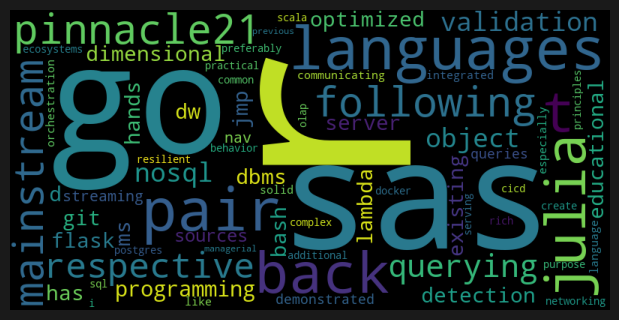

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = {x[0]: x[1] for x in most_similar('python', 100)}
wordcloud = WordCloud(width=800, height=400, min_font_size=12).generate_from_frequencies(text)

plt.figure( figsize=(6, 5), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

## Export the Model

The exported model weights and metadata can be used to visualize the vector space here:
http://projector.tensorflow.org/

In [28]:
out_v = io.open('tf_w2v_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('tf_w2v_metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocabulary):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()